In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import itertools
import seaborn as sns 
from tensorflow import keras
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


<Axes: >

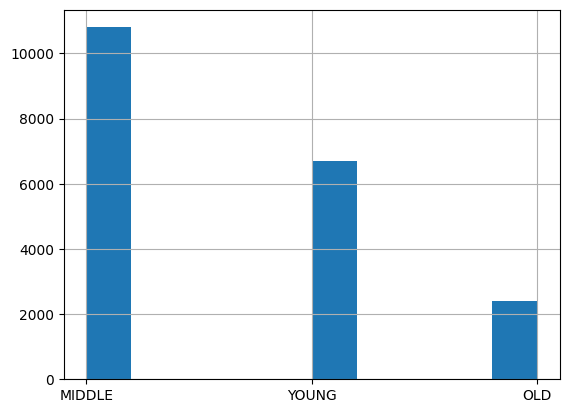

In [3]:
# Create a histogram for all categories in the class variable.
data['Class'].hist()

In [4]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(3)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1


In [5]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [6]:
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [8]:
# built the list of image paths and list of respective responses of the images
PATH = "/content/train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

514
514


In [14]:
train_size = int(0.7*(len(image_paths)))
print(train_size)
test_size = int(0.3*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

359


In [15]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [17]:
# build the layers of CNN model
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [18]:
# view the summary of the cnn model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [19]:
# compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# fit the model
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
6/6 [==============================] - 20s 3s/step - loss: 1.6889 - accuracy: 0.4903 - val_loss: 1.0371 - val_accuracy: 0.4333
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 1.0520 - accuracy: 0.4986 - val_loss: 0.9908 - val_accuracy: 0.5861
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 0.9719 - accuracy: 0.5320 - val_loss: 0.9203 - val_accuracy: 0.6389
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.9149 - accuracy: 0.6212 - val_loss: 0.8770 - val_accuracy: 0.6167
Epoch 5/10
6/6 [==============================] - 17s 3s/step - loss: 0.8512 - accuracy: 0.6602 - val_loss: 0.8333 - val_accuracy: 0.6472
Epoch 6/10
6/6 [==============================] - 17s 3s/step - loss: 0.7926 - accuracy: 0.6825 - val_loss: 0.7847 - val_accuracy: 0.6861
Epoch 7/10
6/6 [==============================] - 18s 3s/step - loss: 0.7167 - accuracy: 0.7103 - val_loss: 0.7295 - val_accuracy: 0.7139
Epoch 8/10
6/6 [==================

In [21]:
ann_model = keras.Sequential([
    layers.Flatten(input_shape=(150, 150, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [22]:
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 67500)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               8640128   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,648,579
Trainable params: 8,648,579
Non-trainable params: 0
_________________________________________________________________


In [23]:
ann_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
ann_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
6/6 [==============================] - 1s 190ms/step - loss: 1.2384 - accuracy: 0.5627 - val_loss: 1.6840 - val_accuracy: 0.4167
Epoch 2/10
6/6 [==============================] - 1s 191ms/step - loss: 1.2599 - accuracy: 0.5822 - val_loss: 1.8622 - val_accuracy: 0.4083
Epoch 3/10
6/6 [==============================] - 1s 197ms/step - loss: 1.3342 - accuracy: 0.5487 - val_loss: 2.3800 - val_accuracy: 0.4250
Epoch 4/10
6/6 [==============================] - 1s 192ms/step - loss: 1.5767 - accuracy: 0.5153 - val_loss: 2.4468 - val_accuracy: 0.4056
Epoch 5/10
6/6 [==============================] - 2s 311ms/step - loss: 1.6895 - accuracy: 0.5376 - val_loss: 2.2338 - val_accuracy: 0.3917
Epoch 6/10
6/6 [==============================] - 2s 250ms/step - loss: 1.7550 - accuracy: 0.4958 - val_loss: 1.6190 - val_accuracy: 0.4500
Epoch 7/10
6/6 [==============================] - 1s 188ms/step - loss: 1.5335 - accuracy: 0.5153 - val_loss: 0.9447 - val_accuracy: 0.6222
Epoch 8/10
6/6 [====

In [25]:
# evaluate the CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(test_set)
print("CNN model accuracy:", cnn_acc)

6/6 [==============================] - 4s 585ms/step - loss: 0.5988 - accuracy: 0.7472
CNN model accuracy: 0.7472222447395325


In [26]:
# evaluate the ANN model
ann_loss, ann_acc = ann_model.evaluate(test_set)
print("ANN model accuracy:", ann_acc)

6/6 [==============================] - 0s 49ms/step - loss: 1.6584 - accuracy: 0.4333
ANN model accuracy: 0.4333333373069763


In [27]:
# evaluate the CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(train_set)
print("CNN model accuracy:", cnn_acc)

6/6 [==============================] - 4s 582ms/step - loss: 0.4056 - accuracy: 0.8357
CNN model accuracy: 0.835654616355896


In [28]:
# evaluate the ANN model
ann_loss, ann_acc = ann_model.evaluate(train_set)
print("ANN model accuracy:", ann_acc)

6/6 [==============================] - 0s 41ms/step - loss: 1.5276 - accuracy: 0.4652
ANN model accuracy: 0.46518105268478394


In [29]:
test_pred = ann_model.predict(test_set)

6/6 [==============================] - 1s 59ms/step


6/6 [==============================] - 0s 38ms/step


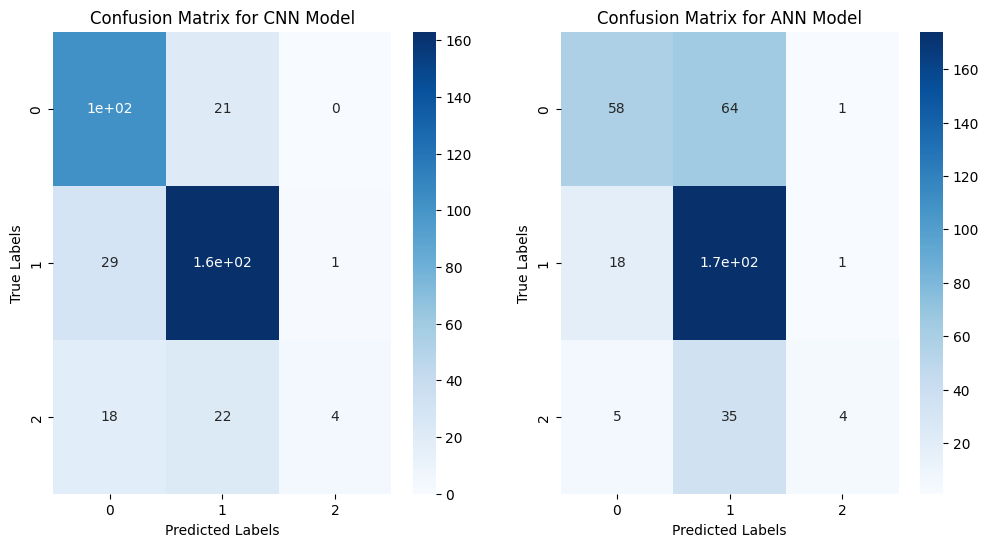

In [41]:
# generate the true class labels for the test set
test_labels = np.concatenate([y for x, y in test_set], axis=0)

# predict probabilities for test set using CNN model
y_prob_cnn = cnn_model.predict(test_set)
# get predicted classes for test set using CNN model
y_pred_cnn = np.argmax(y_prob_cnn, axis=-1)
# generate confusion matrix for CNN model
cm_cnn = confusion_matrix(test_labels, y_pred_cnn)

# predict classes for test set using ANN model
y_pred_ann = np.argmax(ann_model.predict(test_set), axis=-1)
# generate confusion matrix for ANN model
cm_ann = confusion_matrix(test_labels, y_pred_ann)

# plot confusion matrices in subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.heatmap(cm_cnn, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for CNN Model')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
sns.heatmap(cm_ann, annot=True, cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for ANN Model')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')
plt.show()